In [1]:



from finta import TA

import pandas as pd
import yfinance as yf
import pandas as pd
from datetime import datetime
from meteostat import Point, Daily
from functools import reduce

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10



from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.ensemble import RandomForestRegressor
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor


import warnings
warnings.filterwarnings('once')



In [2]:
import pandas as pd
import yfinance as yf
from datetime import datetime

def rsi_calculation(series, periods=14, shift=1):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean().shift(shift)
    loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean().shift(shift)
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def download_stock_data(tech_list):
    end = datetime.now()
    start = datetime(end.year - 20, end.month, end.day)

    company_list = []

    for stock in tech_list:
        data = yf.download(stock, start, end)
        data['Symbol'] = stock  # Ensure 'Symbol' is a column
        company_list.append(data)

    # Concatenate with Symbol as part of the index if that is the intended structure
    df = pd.concat(company_list)
    return df

tech_stocks = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA', 'NVDA']
data = download_stock_data(tech_stocks)

# Remove the reset_index line if 'Symbol' is already a column
# data.reset_index(level='Symbol', inplace=True)

# Calculate moving averages with a shift
for window in [3, 7, 14, 21, 28]:
    data[f'{window}ma'] = data.groupby('Symbol')['Close'].transform(lambda x: x.shift(1).rolling(window).mean())

# Calculate RSI for each group and ensure the index aligns correctly
data['RSI_14'] = data.groupby('Symbol')['Close'].transform(lambda x: rsi_calculation(x, 14, 1))
data['RSI_no_shift'] = data.groupby('Symbol')['Close'].transform(lambda x: rsi_calculation(x, 14, 0))

print(data.tail())


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-04-15  890.979980  906.130005  859.289978  860.010010  860.010010   
2024-04-16  864.330017  881.179993  860.640015  874.150024  874.150024   
2024-04-17  883.400024  887.750000  839.500000  840.349976  840.349976   
2024-04-18  849.700012  861.900024  824.020020  846.710022  846.710022   
2024-04-19  831.500000  843.239990  756.059998  762.000000  762.000000   

              Volume Symbol         3ma         7ma        14ma        21ma  \
Date                                                                          
2024-04-15  44307700   NVDA  886.136658  874.629996  892.277858  894.723331   
2024-04-16  37045300   NVDA  882.676656  874.767142  885.848572  893.798093   
2024-04-17  49540000   NVDA  872.006673  873.920000  882.172860  893.597142   
2024-04-18  44726000   NVDA  858.170003  869.494280  877.733573  891.492379   
2024-04

In [3]:


# Assuming 'data' is your DataFrame
# Ensure your DataFrame is sorted by 'Date' if it's not already
data.sort_values(by=['Date'], inplace=True)




In [4]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
data.dropna(subset=['Close','3ma', '7ma', '14ma', '21ma', '28ma', 'RSI_14' ], inplace=True)
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')
print(len(data))
print(data.info())

Number of rows with missing values: 0.0058809115412889
Number of rows with missing values: 0.0
Number of rows with missing values: 0.0
28399
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28399 entries, 2004-05-28 to 2024-04-19
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          28399 non-null  float64
 1   High          28399 non-null  float64
 2   Low           28399 non-null  float64
 3   Close         28399 non-null  float64
 4   Adj Close     28399 non-null  float64
 5   Volume        28399 non-null  int64  
 6   Symbol        28399 non-null  object 
 7   3ma           28399 non-null  float64
 8   7ma           28399 non-null  float64
 9   14ma          28399 non-null  float64
 10  21ma          28399 non-null  float64
 11  28ma          28399 non-null  float64
 12  RSI_14        28399 non-null  float64
 13  RSI_no_shift  28399 non-null  float64
dtypes: float64(12), int64(1), object(1)
memo

Train error: 0.20431159318677033
Test error: 2.466994034000234


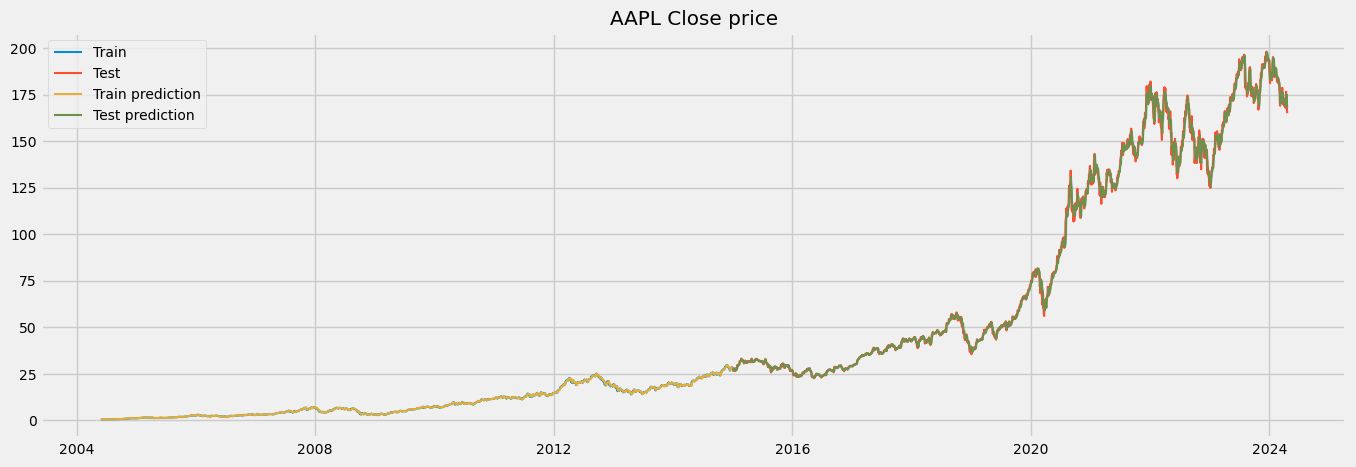

In [5]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
#convert Date to index
#data.set_index('Date', inplace=True)

data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = Ridge()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


# SGQRegressor

Train error: 0.27589416231942154
Test error: 3.7408234749838583


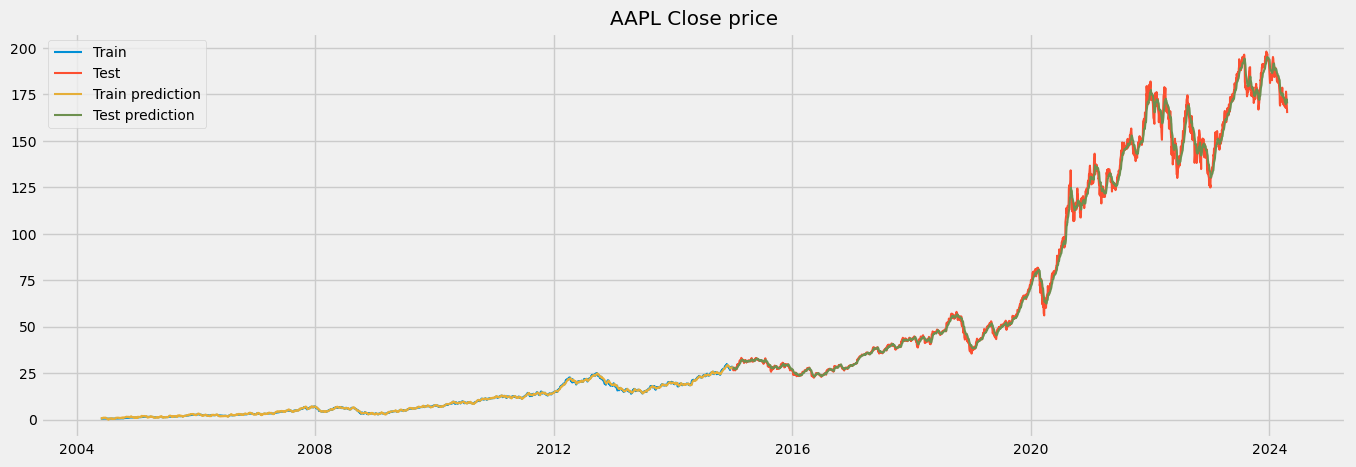

In [6]:
#forcast the close price using the 25ma and 50ma
#train the model_Ridge
data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'  ]]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model_Ridge = SGDRegressor()
model_Ridge.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results
plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()


# XGBoost

Train error: 0.27589416231942154
Test error: 3.7408234749838583


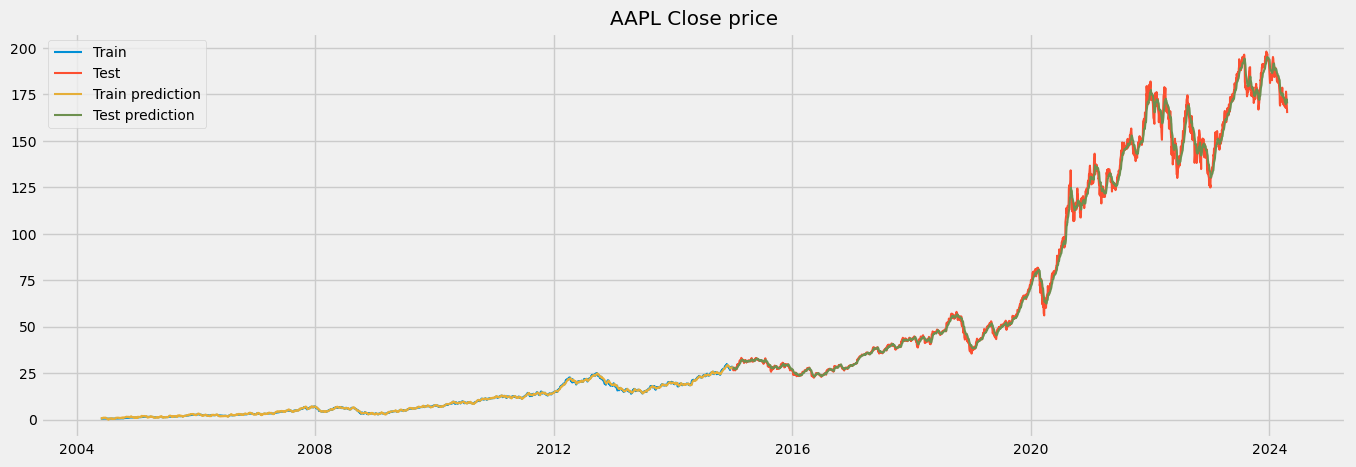

In [7]:
data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#train the model_Ridge
model = XGBRegressor(n_estimators=100)
model.fit(X_train_scaled, y_train)

#predict the close price
y_train_pred = model_Ridge.predict(X_train_scaled)

y_test_pred = model_Ridge.predict(X_test_scaled)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'


#plot the results

plt.figure(figsize=(15, 5))
plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()


In [8]:
#predictict with a 1D Convolutional Neural Network
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten
from keras.layers import MaxPooling1D, Dropout

data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

shape = X_train.shape[1]
#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

#reshape the data
X_train_reshaped = X_train_scaled.reshape(-1, shape, 1)

X_test_reshaped = X_test_scaled.reshape(-1, shape, 1)

#train the model

model = Sequential()
model.add(Conv1D(256, 2, activation='relu', input_shape=(shape, 1)))
#dropout layer
model.add(Dropout(0.2))
model.add(Conv1D(256, 2, activation='relu'))
model.add(MaxPooling1D())


model.add(Flatten())
model.add(Dense(60, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.fit(X_train_reshaped, y_train, epochs=25, verbose=1, batch_size=16)

#predict the close price
y_train_pred = model.predict(X_train_reshaped)

y_test_pred = model.predict(X_test_reshaped)

#print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')


#filter predictions and actual values by one symbol == 'AAPL'

plt.figure(figsize=(15, 5))

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

data_train = data.loc[data.index < '2015-01-01']
data_test = data.loc[data.index >= '2015-01-01']

X_train = data_train[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_train = data_train['Close']

X_test = data_test[['3ma','7ma', '14ma', '21ma', '28ma', 'RSI_14'   ]]
y_test = data_test['Close']

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

shape = X_train.shape[1]

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape(-1, shape, 1)
X_test_reshaped = X_test_scaled.reshape(-1, shape, 1)

# Build the LSTM model
model = Sequential()
model.add(LSTM(256, activation='selu', input_shape=(shape, 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(256, activation='selu', return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(128, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(60, activation='selu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, verbose=1, batch_size=32)

# Predict the close price
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)

# Print train and test error
print(f'Train error: {mean_absolute_error(y_train, y_train_pred)}')
print(f'Test error: {mean_absolute_error(y_test, y_test_pred)}')

# Filter predictions and actual values by one symbol == 'AAPL'
plt.figure(figsize=(15, 5))

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, data_train.loc[data_train['Symbol'] == 'AAPL']['Close'], label='Train')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, data_test.loc[data_test['Symbol'] == 'AAPL']['Close'], label='Test')

plt.plot(data_train.loc[data_train['Symbol'] == 'AAPL'].index, y_train_pred[data_train['Symbol'] == 'AAPL'], label='Train prediction')
plt.plot(data_test.loc[data_test['Symbol'] == 'AAPL'].index, y_test_pred[data_test['Symbol'] == 'AAPL'], label='Test prediction')

plt.title('AAPL Close price')
plt.legend()
plt.show()


Epoch 1/50


449/449 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 21.3397 - mae: 2.3821
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 2.4019 - mae: 1.0356
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 2.2025 - mae: 0.9921
Epoch 4/50
304/449 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 1.6710 - mae: 0.8560